In [1]:
 """
 Script to calculate generality and  application data
 Generality: how diverse is the impact of a patent
 This is done by calculating the herfindal index of citing patents

 Nov 19th, 2020
 This version runs in 
 CPU times: user 31min 5s, sys: 2min 56s, total: 34min 2s
 Wall time: 37min 12s
 Now I add modifications to allow calculation of originality
 To do that, I match classification to patent_id and change the grouping to citation_id
 I think it may be best to change the index to patent_id upfront, then only create an if condition in the grouping section.
 
 Feb 7th, 2020
 While the previous version is already up, I want to improve the script
 I want to make calculations with only one script
 Also, I want to compare different class systems
 this version took 10 minutes - i am moving the old version away

 Jan 16th, 2020
 Due to performance problems in the HPC, this script was divided in two, the script following this is generality_2
 generality > 1 is not an error, but a consequence of adopting WIPO
 it seems that the original calculation had only one class per patent
 WIPO provides multiple classes - so when you divide by the total number of citations, 
  you do not have the proportion of classes cited anymore
 to correct this issue, I can calculate Generality and Originality based only on the first WIPO class

 Jan 13th, 2020
 Script is running but there are two major issues
 - there should not exist generality > 1 , so there is an error in calculation
 - too many NANs (about 400k), but I will tackle this issue in 'too_many_nans.ipynb'

 to tackle the first problem, I'll begin by creating a subset of the database
 to do that, I'll use USPTO classification system
 """

"\nScript to calculate generality and  application data\nGenerality: how diverse is the impact of a patent\nThis is done by calculating the herfindal index of citing patents\n\nNov 19th, 2020\nThis version runs in \nCPU times: user 31min 5s, sys: 2min 56s, total: 34min 2s\nWall time: 37min 12s\nNow I add modifications to allow calculation of originality\nTo do that, I match classification to patent_id and change the grouping to citation_id\nI think it may be best to change the index to patent_id upfront, then only create an if condition in the grouping section.\n\nFeb 7th, 2020\nWhile the previous version is already up, I want to improve the script\nI want to make calculations with only one script\nAlso, I want to compare different class systems\nthis version took 10 minutes - i am moving the old version away\n\nJan 16th, 2020\nDue to performance problems in the HPC, this script was divided in two, the script following this is generality_2\ngenerality > 1 is not an error, but a consequ

In [2]:
import pandas as pd
import numpy as np
import re

import dask.dataframe as dd
from dask.delayed import delayed

import glob
import graphviz

file_list=glob.glob("data/citation/*")
classification = 'data/wipo.parquet.gz'

class_df=pd.read_parquet(classification, columns=['wipo_sector_id'])

In [3]:
def join_class(df, class_df):
    df=df.merge(class_df, how='inner', right_index=True, left_index=True)
    return df

In [4]:
#this function reads the custom-made wipo groups and prepare the dict for aggregation
#the aggregation features one count and sums for all classes
def wipo_categories():
    file_classes = 'data/classes.csv.gz'
    classes=pd.read_csv(file_classes, compression='gzip')
    classes=classes[classes['system']=='wipo_field_id'].sector_title.unique().tolist()
    aggregation={}
    for i, element in enumerate(classes):
        if i==0:
                aggregation[element]=['count','sum']
        else:
            aggregation[element]='sum'
    return aggregation

In [5]:
#test gen_orig(df)
def test_gen_orig():
    df1 = pd.DataFrame(np.random.randint(0,5,size=(10, 1)), columns=['wipo_sector_id'])
    df2 = pd.DataFrame(np.random.randint(0,5,size=(10, 1)), columns=['wipo_sector_id'])
    df3 = pd.DataFrame(np.random.randint(0,5,size=(10, 1)), columns=['wipo_sector_id'])
    df=pd.concat([df1, df2, df3])
    print(df.values)
#     print(gen_orig(df))
    return gen_orig(df)

In [6]:
# receives a table made by prepare_df and calculates 1-herfindal
# this function calculates generality based on Herfindal index
# Herfindal is the sum of the squares divided by the square of the sum of citations
# it is a measure of concentration

# i separate from prepare_df() to make testing easier
def gen_orig(df, originality=False):
    df=pd.get_dummies(df, columns=['wipo_sector_id'])
    if originality:
        df=df.groupby(df['patent_id']).sum()
        column='originality'
    else:
        df=df.groupby(df['citation_id']).sum()
        column='generality'
    df[column] = 1-(df.apply(np.square).apply(np.sum, axis='columns')/df.apply(np.sum, axis='columns').apply(np.square))
    return df


In [7]:
# patent_id is the citing patent
# citation_id (the index) is the cited patent

In [8]:
def generality(originality=False):
    if originality:
        dfs = [dd.read_parquet(f, columns=['patent_id']).reset_index().set_index('patent_id') for f in file_list]
        dst= 'data/originality.parquet.gz'
    else:
        dfs = [dd.read_parquet(f, columns=['patent_id']) for f in file_list]
        dst= 'data/generality.parquet.gz'

    
    for i,dfx in enumerate(dfs):
        dfx=join_class(dfx, class_df) #merge into indexes means merging class with citation_id - thus generality
        if i==0:
            df=dfx
        else:
            df=dd.concat([df,dfx])

    df=df.repartition(npartitions=8)
    df=delayed(gen_orig)(df,originality)

    return df, dst

In [9]:
df, dst=generality(originality=True)
df.visualize()

In [10]:
%%time
df.compute()[['originality']].to_parquet(dst, compression='gzip')

CPU times: user 35min 59s, sys: 1min 45s, total: 37min 44s
Wall time: 36min 51s


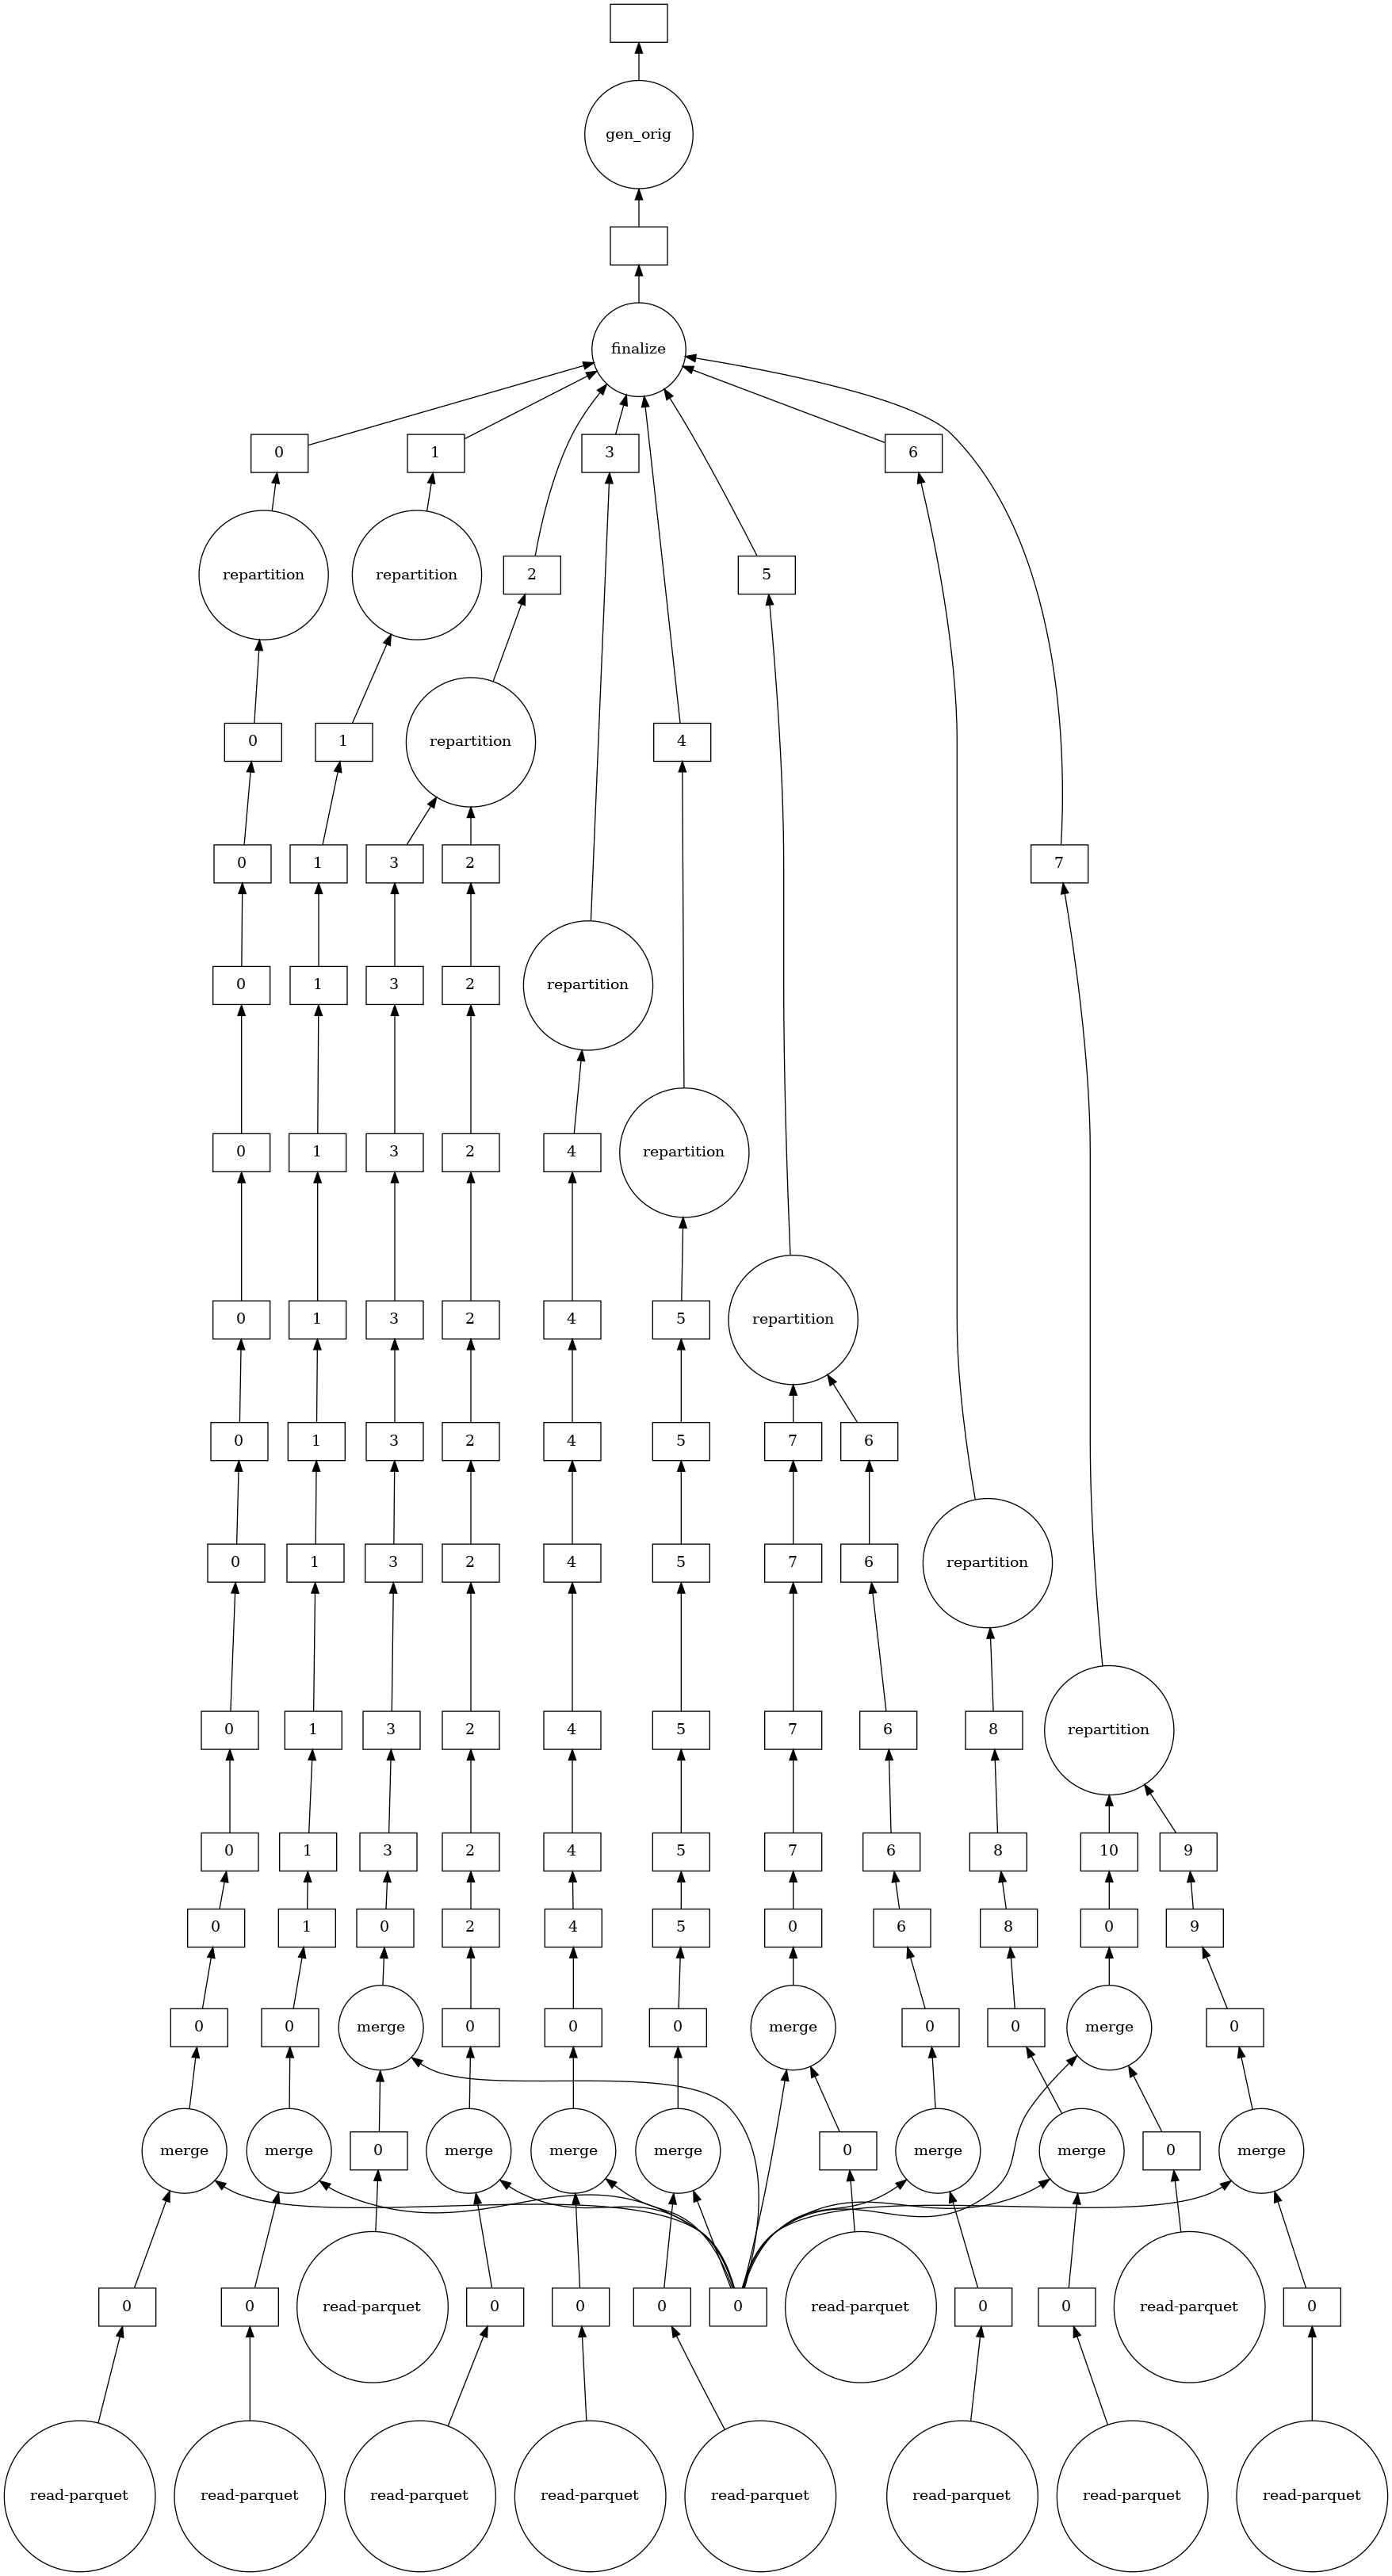

In [11]:
df, dst=generality()
df.visualize()

In [12]:
%%time
df=df.compute()
df[['generality']].to_parquet(dst, compression='gzip')

CPU times: user 31min 12s, sys: 3min 1s, total: 34min 13s
Wall time: 38min 21s


In [14]:
df[['generality']].head()


,generality
patent_id,
10000000,0.000000
10000001,0.000000
10000002,0.444444
10000003,0.000000
10000004,0.000000
